In [ ]:
import numpy as nm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

#### Implement a Time Series Forecasting model in Python, by using the FBProphet module. The forecasting model should be able to predict the Sunspots (see below) by using Facebook’s Prophet Time Series Forecasting model.Source: https://en.wikipedia.org/wiki/Sunspot
#### Monthly data: http://www.sidc.be/silso/infosnmtot


## MONTHLY TIMESERIES

In [ ]:
monthly = pd.read_csv("SN_m_tot_V2.0.csv")

### Analyzing the Data

In [ ]:
monthly.head()

1749;01;1749.042;  96.7; -1.0;   -1;1
0  1749;02;1749.123; 104.3; -1.0;   -1;1
1  1749;03;1749.204; 116.7; -1.0;   -1;1
2  1749;04;1749.288;  92.8; -1.0;   -1;1
3  1749;05;1749.371; 141.7; -1.0;   -1;1
4  1749;06;1749.455; 139.2; -1.0;   -1;1

In [ ]:
monthly.shape

(3279, 1)

In [ ]:
monthly.columns

Index(['1749;01;1749.042;  96.7; -1.0;   -1;1'], dtype='object')

In [ ]:
m = monthly.copy()

In [ ]:
m.isnull().values.any()

False

In [ ]:
m = m["1749;01;1749.042;  96.7; -1.0;   -1;1"].str.split(";", expand = True)
m.head()

0   1         2       3      4      5  6
0  1749  02  1749.123   104.3   -1.0     -1  1
1  1749  03  1749.204   116.7   -1.0     -1  1
2  1749  04  1749.288    92.8   -1.0     -1  1
3  1749  05  1749.371   141.7   -1.0     -1  1
4  1749  06  1749.455   139.2   -1.0     -1  1

In [ ]:
m.shape

(3279, 7)

In [ ]:
m = m.rename(columns = {0: "year", 1: "month", 2: "date_in_fraction", 3: "monthly_mean_sunspot_num",
                        4: "monthly_mean_sunspot_std", 5: "observations", 6: "indicator"})

In [ ]:
new_row = pd.DataFrame({"year": "1749", "month": "01", "date_in_fraction": "1749.042", "monthly_mean_sunspot_num": "96.7",
                        "monthly_mean_sunspot_std": "-1.0", "observations": "-1", "indicator": "1"}, index = [0])

m = pd.concat([new_row, m]).reset_index(drop = True)

In [ ]:
m.head()

year month date_in_fraction monthly_mean_sunspot_num  \
0  1749    01         1749.042                     96.7   
1  1749    02         1749.123                    104.3   
2  1749    03         1749.204                    116.7   
3  1749    04         1749.288                     92.8   
4  1749    05         1749.371                    141.7   

  monthly_mean_sunspot_std observations indicator  
0                     -1.0           -1         1  
1                     -1.0           -1         1  
2                     -1.0           -1         1  
3                     -1.0           -1         1  
4                     -1.0           -1         1

In [ ]:
m.columns

Index(['year', 'month', 'date_in_fraction', 'monthly_mean_sunspot_num',
       'monthly_mean_sunspot_std', 'observations', 'indicator'],
      dtype='object')

In [ ]:
m1 = m.copy()
m1.shape

(3280, 7)

In [ ]:
m1.isnull().values.any()

False

### Make code agnostic of the input, i.e., have your code determine the unit of the time series.

In [ ]:
from datetime import datetime
m1["year_month_int"] = m1["year"].astype(str) + m1["month"].astype(str).str.zfill(2)
m1["year_month"] = pd.to_datetime(m1["year_month_int"], format = "%Y%m")
m1 = m1.drop(columns = ["year_month_int"])

In [ ]:
m1.columns

Index(['year', 'month', 'date_in_fraction', 'monthly_mean_sunspot_num',
       'monthly_mean_sunspot_std', 'observations', 'indicator', 'year_month'],
      dtype='object')

In [ ]:
m1.dtypes

year                                object
month                               object
date_in_fraction                    object
monthly_mean_sunspot_num            object
monthly_mean_sunspot_std            object
observations                        object
indicator                           object
year_month                  datetime64[ns]
dtype: object

In [ ]:
m1["year"] = m1["year"].astype("float")
m1["month"] = m1["month"].astype("float")
m1["monthly_mean_sunspot_num"] = m1["monthly_mean_sunspot_num"].astype("float")
m1["observations"] = m1["observations"].astype("float")
m1["indicator"] = m1["indicator"].astype("float")
m1.dtypes

year                               float64
month                              float64
date_in_fraction                    object
monthly_mean_sunspot_num           float64
monthly_mean_sunspot_std            object
observations                       float64
indicator                          float64
year_month                  datetime64[ns]
dtype: object

In [ ]:
m1.tail()

year  month date_in_fraction  monthly_mean_sunspot_num  \
3275  2021.0   12.0         2021.958                      67.5   
3276  2022.0    1.0         2022.042                      54.0   
3277  2022.0    2.0         2022.122                      59.7   
3278  2022.0    3.0         2022.204                      78.5   
3279  2022.0    4.0         2022.286                      84.1   

     monthly_mean_sunspot_std  observations  indicator year_month  
3275                     15.6         845.0        1.0 2021-12-01  
3276                     12.9        1007.0        0.0 2022-01-01  
3277                     13.1        1044.0        0.0 2022-02-01  
3278                     13.9        1277.0        0.0 2022-03-01  
3279                     15.2        1237.0        0.0 2022-04-01

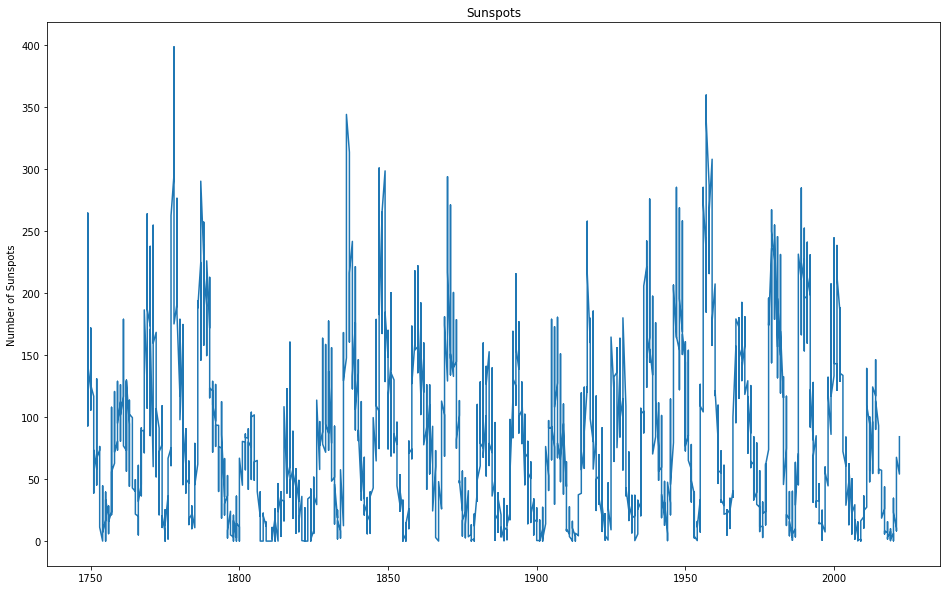

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(m1["year"], m1["monthly_mean_sunspot_num"])
plt.title("Sunspots")
plt.ylabel("Number of Sunspots")
plt.show()

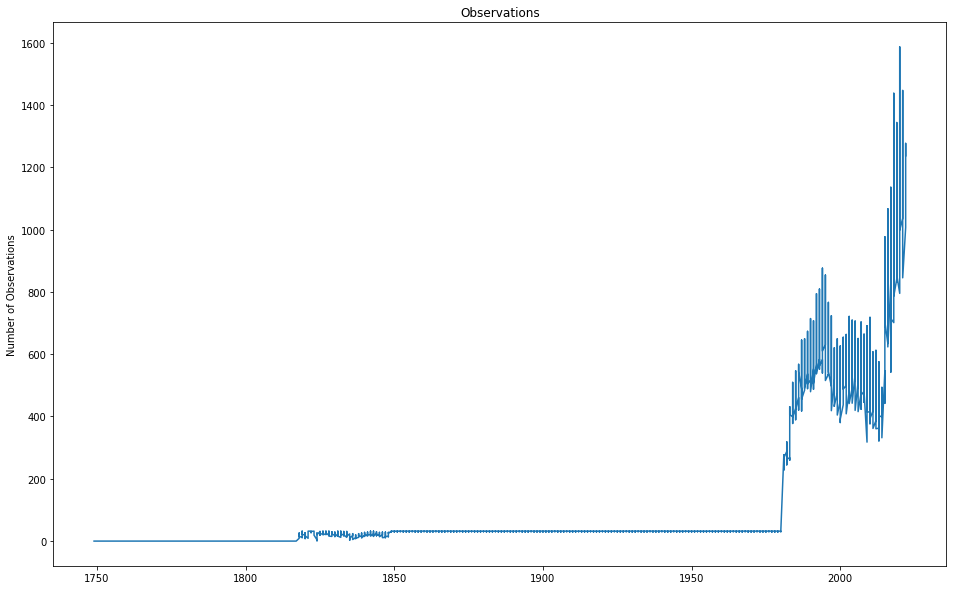

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(m1["year"], m1["observations"])
plt.title("Observations")
plt.ylabel("Number of Observations")
plt.show()

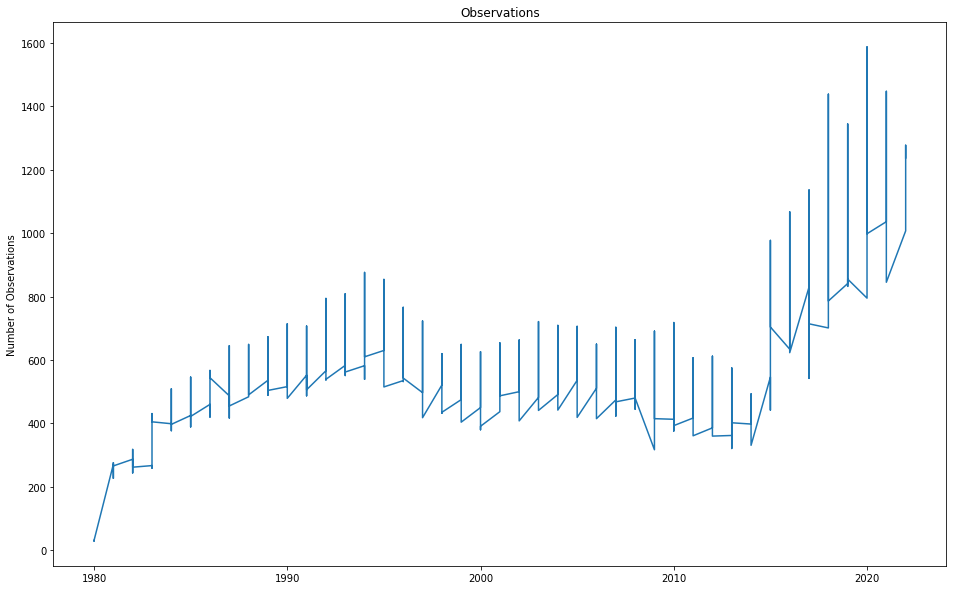

In [ ]:
m1_zoomed_in = m1.loc[m1["year"].between(1980, 2022)]

plt.figure(figsize = (16, 10))
plt.plot(m1_zoomed_in["year"], m1_zoomed_in["observations"])
plt.title("Observations")
plt.ylabel("Number of Observations")
plt.show()

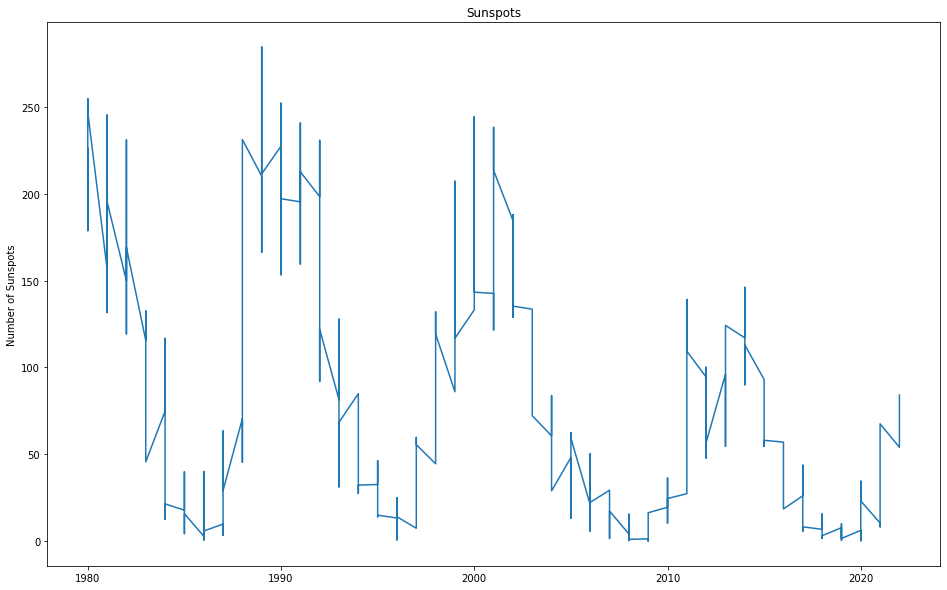

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(m1_zoomed_in["year"], m1_zoomed_in["monthly_mean_sunspot_num"])
plt.title("Sunspots")
plt.ylabel("Number of Sunspots")
plt.show()

### Training the model and predicting Sunspots values from the last date of the dataset into X units of time into the future.

Should the unit of time be month, predict the number of sunspots for 1/6/9 months into the future.

Tuning FBProphet model on the following parameters:

a) Forecasting growth: Plausible values = logistic; linear; flat https://facebook.github.io/prophet/docs/saturating_forecasts.html

b) Seasonality: Add manual seasonality by using the add_seasonality method. Test it with various values for ‘period’ and ‘fourier_order’. https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

c) Trend Changepoints: Tune the ‘n_changepoints’ and ‘changepoit_prior_scale’ arguments/parameters https://facebook.github.io/prophet/docs/trend_changepoints.html

In [ ]:
mdf = m1[["year_month", "monthly_mean_sunspot_num"]]
mdf.tail()

year_month  monthly_mean_sunspot_num
3275 2021-12-01                      67.5
3276 2022-01-01                      54.0
3277 2022-02-01                      59.7
3278 2022-03-01                      78.5
3279 2022-04-01                      84.1

In [ ]:
col_dict = {"year_month": "ds", \
            "monthly_mean_sunspot_num": "y"}

mdf.columns = [col_dict.get(x, x) for x in mdf.columns]
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3280 entries, 0 to 3279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3280 non-null   datetime64[ns]
 1   y       3280 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.4 KB


In [ ]:
mdf = mdf.assign(y = (mdf["y"]))

In [ ]:
mdf.head()

ds      y
0 1749-01-01   96.7
1 1749-02-01  104.3
2 1749-03-01  116.7
3 1749-04-01   92.8
4 1749-05-01  141.7

#### Seasonality

In [ ]:
model = Prophet()

In [ ]:
model.fit(mdf)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
s1_future = model.make_future_dataframe(periods = 1, freq = "m")
s1_future.tail()

ds
3276 2022-01-01
3277 2022-02-01
3278 2022-03-01
3279 2022-04-01
3280 2022-04-30

In [ ]:
s1_prediction = model.predict(s1_future)
s1_prediction

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1749-01-01  94.733331   11.410257  175.538651    94.733331    94.733331   
1    1749-02-01  94.696797    6.928032  171.805099    94.696797    94.696797   
2    1749-03-01  94.663798    8.644069  180.297489    94.663798    94.663798   
3    1749-04-01  94.627264    3.479353  176.078068    94.627264    94.627264   
4    1749-05-01  94.591908   13.848670  183.988642    94.591908    94.591908   
...         ...        ...         ...         ...          ...          ...   
3276 2022-01-01  58.253343  -31.607071  144.069475    58.253343    58.253343   
3277 2022-02-01  58.177463  -15.108819  141.425329    58.177463    58.177463   
3278 2022-03-01  58.108926  -28.385709  138.914509    58.108926    58.108926   
3279 2022-04-01  58.033046  -22.347517  144.129281    58.033046    58.033046   
3280 2022-04-30  57.962062  -31.481198  129.830191    57.962062    57.962062   

      additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0          -4.171313             -4.171313             -4.171313 -4.171313   
1          -2.235292             -2.235292             -2.235292 -2.235292   
2          -3.999776             -3.999776             -3.999776 -3.999776   
3          -0.308467             -0.308467             -0.308467 -0.308467   
4           5.476867              5.476867              5.476867  5.476867   
...              ...                   ...                   ...       ...   
3276       -3.072669             -3.072669             -3.072669 -3.072669   
3277        0.331999              0.331999              0.331999  0.331999   
3278       -0.258519             -0.258519             -0.258519 -0.258519   
3279       -1.046352             -1.046352             -1.046352 -1.046352   
3280       -4.547421             -4.547421             -4.547421 -4.547421   

      yearly_lower  yearly_upper  multiplicative_terms  \
0        -4.171313     -4.171313                   0.0   
1        -2.235292     -2.235292                   0.0   
2        -3.999776     -3.999776                   0.0   
3        -0.308467     -0.308467                   0.0   
4         5.476867      5.476867                   0.0   
...            ...           ...                   ...   
3276     -3.072669     -3.072669                   0.0   
3277      0.331999      0.331999                   0.0   
3278     -0.258519     -0.258519                   0.0   
3279     -1.046352     -1.046352                   0.0   
3280     -4.547421     -4.547421                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                            0.0                         0.0   90.562019  
1                            0.0                         0.0   92.461505  
2                            0.0                         0.0   90.664022  
3                            0.0                         0.0   94.318797  
4                            0.0                         0.0  100.068776  
...                          ...                         ...         ...  
3276                         0.0                         0.0   55.180674  
3277                         0.0                         0.0   58.509462  
3278                         0.0                         0.0   57.850407  
3279                         0.0                         0.0   56.986694  
3280                         0.0                         0.0   53.414640  

[3281 rows x 16 columns]

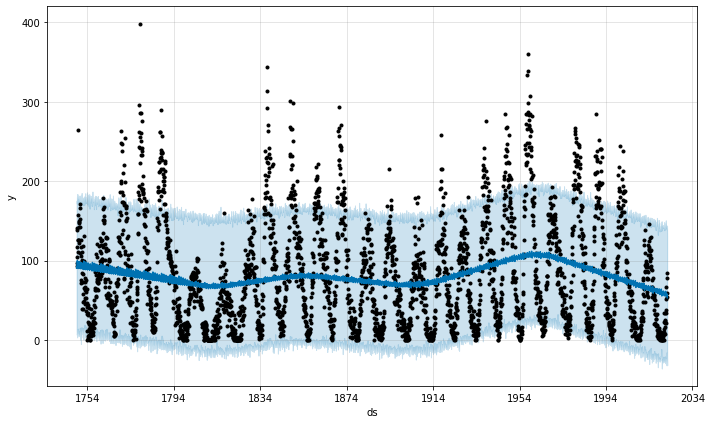

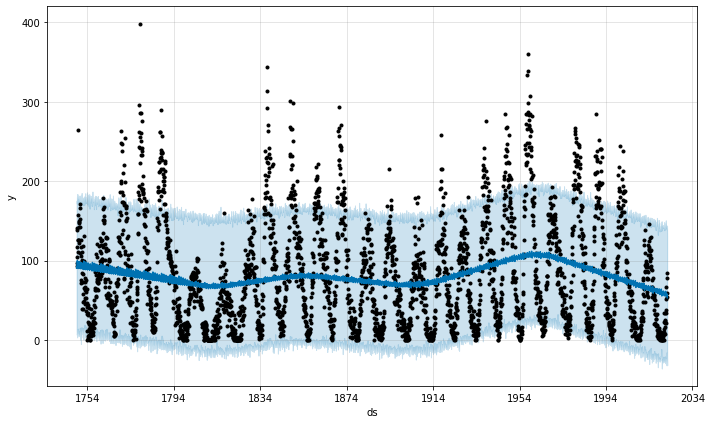

In [ ]:
model.plot(s1_prediction)

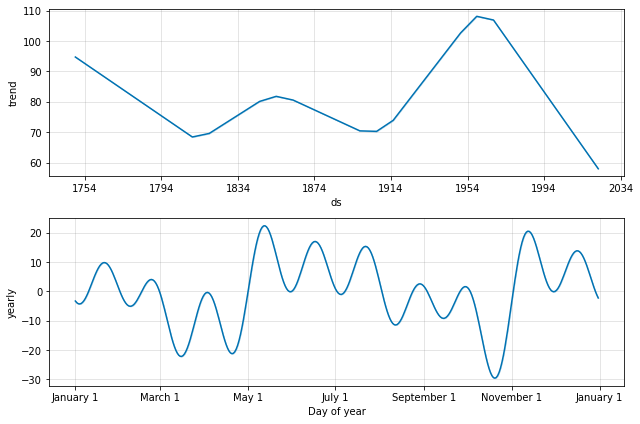

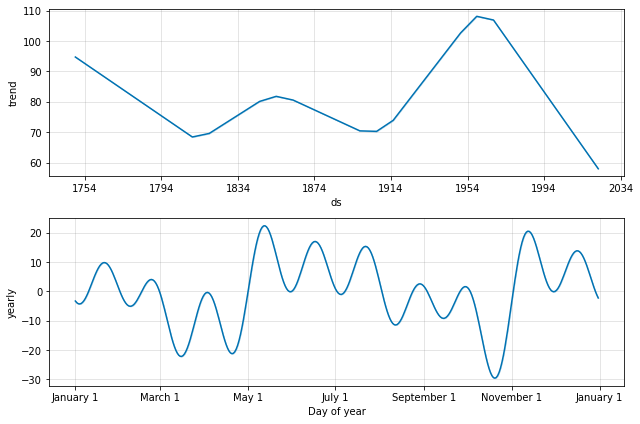

In [ ]:
model.plot_components(s1_prediction)

In [ ]:
s6_future = model.make_future_dataframe(periods = 6, freq = "m")
s6_future.tail()

ds
3281 2022-05-31
3282 2022-06-30
3283 2022-07-31
3284 2022-08-31
3285 2022-09-30

In [ ]:
s6_prediction = model.predict(s6_future)
s6_prediction

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1749-01-01  94.733331    3.338598  178.019628    94.733331    94.733331   
1    1749-02-01  94.696797   -0.965359  179.075006    94.696797    94.696797   
2    1749-03-01  94.663798    9.123363  173.603200    94.663798    94.663798   
3    1749-04-01  94.627264    7.021781  174.148662    94.627264    94.627264   
4    1749-05-01  94.591908   12.842899  185.106274    94.591908    94.591908   
...         ...        ...         ...         ...          ...          ...   
3281 2022-05-31  57.886182  -20.371694  141.149384    57.886182    57.886182   
3282 2022-06-30  57.812749  -23.622938  148.684000    57.812749    57.812749   
3283 2022-07-31  57.736869  -17.621358  154.971738    57.736869    57.736869   
3284 2022-08-31  57.660989  -24.742100  146.445683    57.660989    57.660989   
3285 2022-09-30  57.587557  -29.173875  143.110157    57.587557    57.587557   

      additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0          -4.171313             -4.171313             -4.171313 -4.171313   
1          -2.235292             -2.235292             -2.235292 -2.235292   
2          -3.999776             -3.999776             -3.999776 -3.999776   
3          -0.308467             -0.308467             -0.308467 -0.308467   
4           5.476867              5.476867              5.476867  5.476867   
...              ...                   ...                   ...       ...   
3281       -0.098553             -0.098553             -0.098553 -0.098553   
3282        2.351768              2.351768              2.351768  2.351768   
3283        5.305223              5.305223              5.305223  5.305223   
3284        2.214813              2.214813              2.214813  2.214813   
3285        1.668490              1.668490              1.668490  1.668490   

      yearly_lower  yearly_upper  multiplicative_terms  \
0        -4.171313     -4.171313                   0.0   
1        -2.235292     -2.235292                   0.0   
2        -3.999776     -3.999776                   0.0   
3        -0.308467     -0.308467                   0.0   
4         5.476867      5.476867                   0.0   
...            ...           ...                   ...   
3281     -0.098553     -0.098553                   0.0   
3282      2.351768      2.351768                   0.0   
3283      5.305223      5.305223                   0.0   
3284      2.214813      2.214813                   0.0   
3285      1.668490      1.668490                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                            0.0                         0.0   90.562019  
1                            0.0                         0.0   92.461505  
2                            0.0                         0.0   90.664022  
3                            0.0                         0.0   94.318797  
4                            0.0                         0.0  100.068776  
...                          ...                         ...         ...  
3281                         0.0                         0.0   57.787629  
3282                         0.0                         0.0   60.164517  
3283                         0.0                         0.0   63.042092  
3284                         0.0                         0.0   59.875802  
3285                         0.0                         0.0   59.256047  

[3286 rows x 16 columns]

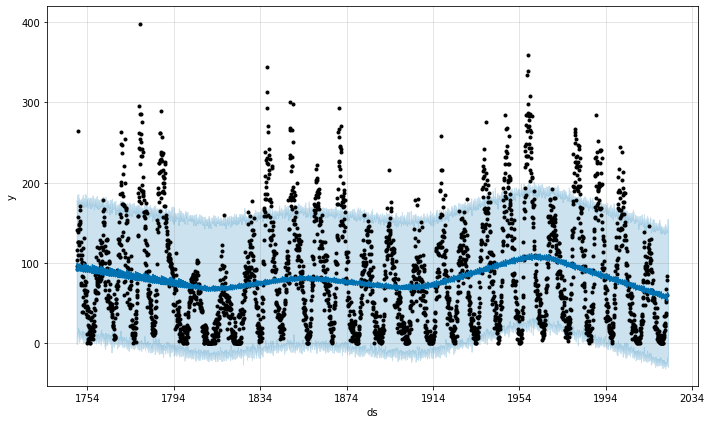

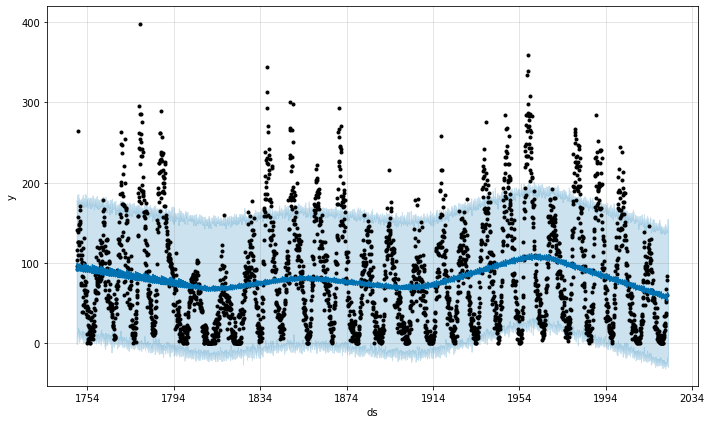

In [ ]:
model.plot(s6_prediction)

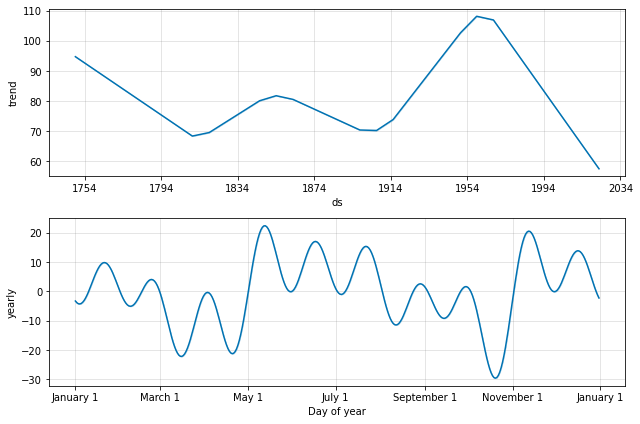

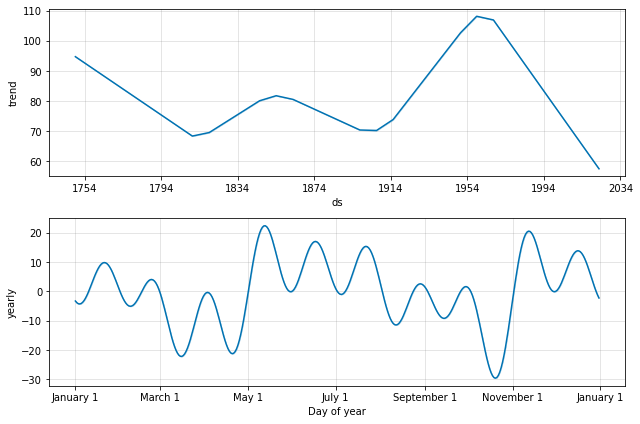

In [ ]:
model.plot_components(s6_prediction)

In [ ]:
s9_future = model.make_future_dataframe(periods = 9, freq = "m")
s9_future.tail()

ds
3284 2022-08-31
3285 2022-09-30
3286 2022-10-31
3287 2022-11-30
3288 2022-12-31

In [ ]:
s9_prediction = model.predict(s9_future)
s9_prediction

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1749-01-01  94.733331    5.349407  177.664205    94.733331    94.733331   
1    1749-02-01  94.696797    7.922881  178.965609    94.696797    94.696797   
2    1749-03-01  94.663798    9.246390  181.172852    94.663798    94.663798   
3    1749-04-01  94.627264    7.447919  173.266191    94.627264    94.627264   
4    1749-05-01  94.591908   21.437531  189.169754    94.591908    94.591908   
...         ...        ...         ...         ...          ...          ...   
3284 2022-08-31  57.660989  -18.745166  148.391928    57.660989    57.660989   
3285 2022-09-30  57.587557  -29.241619  141.825581    57.587557    57.587557   
3286 2022-10-31  57.511677  -29.624837  130.809937    57.511677    57.511677   
3287 2022-11-30  57.438244  -26.906506  142.438339    57.438244    57.438244   
3288 2022-12-31  57.362364  -31.740854  142.646571    57.362364    57.362364   

      additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0          -4.171313             -4.171313             -4.171313 -4.171313   
1          -2.235292             -2.235292             -2.235292 -2.235292   
2          -3.999776             -3.999776             -3.999776 -3.999776   
3          -0.308467             -0.308467             -0.308467 -0.308467   
4           5.476867              5.476867              5.476867  5.476867   
...              ...                   ...                   ...       ...   
3284        2.214813              2.214813              2.214813  2.214813   
3285        1.668490              1.668490              1.668490  1.668490   
3286       -7.133296             -7.133296             -7.133296 -7.133296   
3287       -0.073615             -0.073615             -0.073615 -0.073615   
3288       -1.969046             -1.969046             -1.969046 -1.969046   

      yearly_lower  yearly_upper  multiplicative_terms  \
0        -4.171313     -4.171313                   0.0   
1        -2.235292     -2.235292                   0.0   
2        -3.999776     -3.999776                   0.0   
3        -0.308467     -0.308467                   0.0   
4         5.476867      5.476867                   0.0   
...            ...           ...                   ...   
3284      2.214813      2.214813                   0.0   
3285      1.668490      1.668490                   0.0   
3286     -7.133296     -7.133296                   0.0   
3287     -0.073615     -0.073615                   0.0   
3288     -1.969046     -1.969046                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                            0.0                         0.0   90.562019  
1                            0.0                         0.0   92.461505  
2                            0.0                         0.0   90.664022  
3                            0.0                         0.0   94.318797  
4                            0.0                         0.0  100.068776  
...                          ...                         ...         ...  
3284                         0.0                         0.0   59.875802  
3285                         0.0                         0.0   59.256047  
3286                         0.0                         0.0   50.378381  
3287                         0.0                         0.0   57.364629  
3288                         0.0                         0.0   55.393318  

[3289 rows x 16 columns]

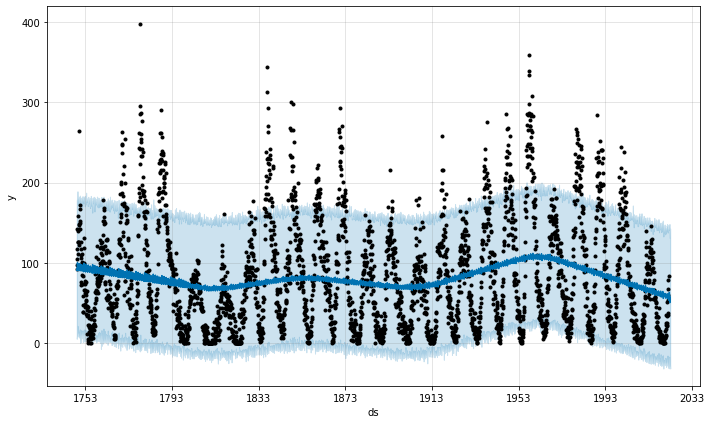

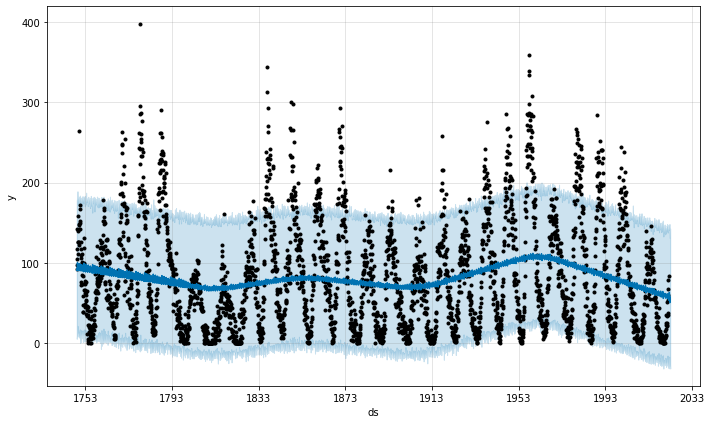

In [ ]:
model.plot(s9_prediction)

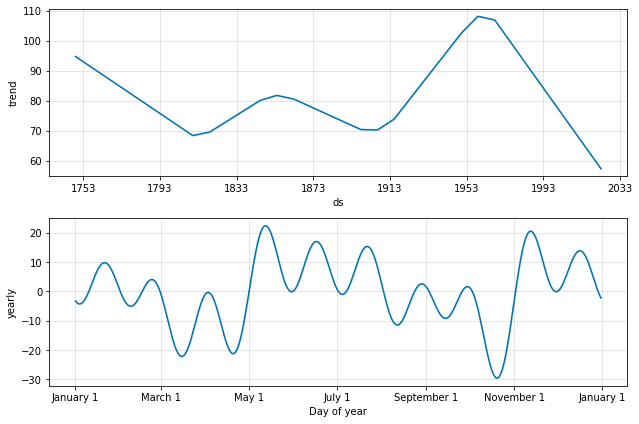

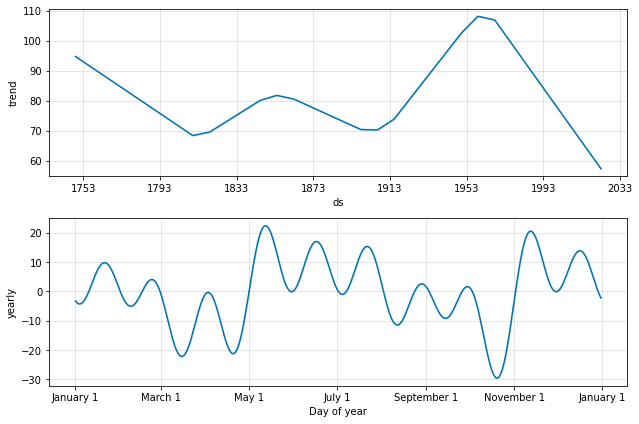

In [ ]:
model.plot_components(s9_prediction)

#### Forecasting Growth

In [ ]:
model = Prophet(growth = "linear")
model.fit(mdf)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future1 = model.make_future_dataframe(periods = 1, freq = "m")
linear1_prediction = model.predict(future1)

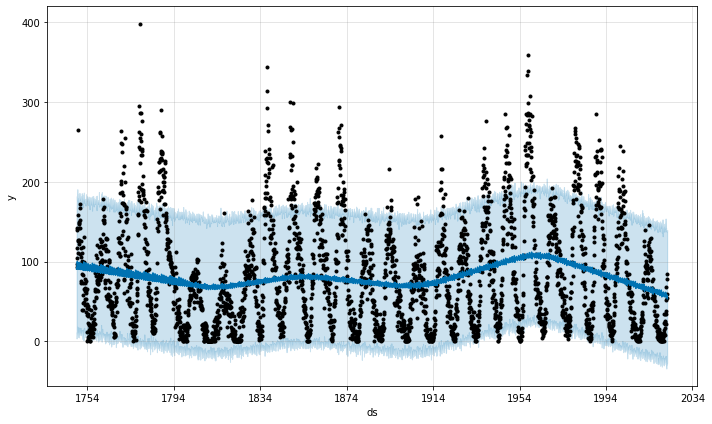

In [ ]:
fig = model.plot(linear1_prediction)

In [ ]:
future6 = model.make_future_dataframe(periods = 6, freq = "m")
linear6_prediction = model.predict(future6)

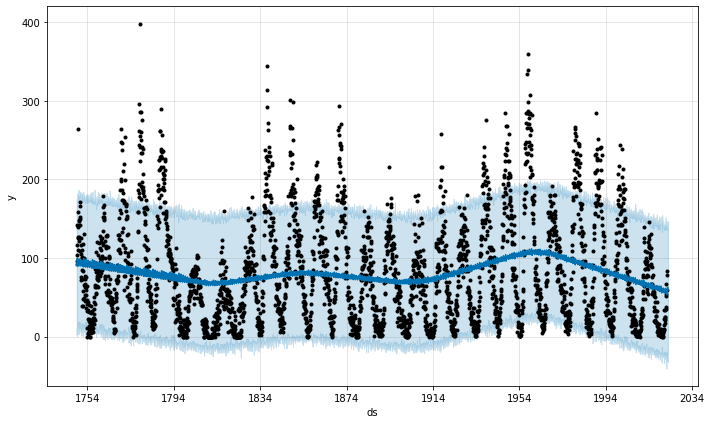

In [ ]:
fig = model.plot(linear6_prediction)

In [ ]:
future9 = model.make_future_dataframe(periods = 9, freq = "m")
linear9_prediction = model.predict(future9)

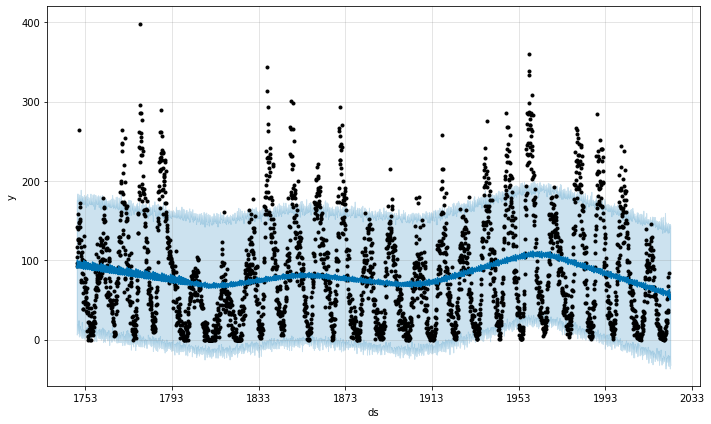

In [ ]:
fig = model.plot(linear9_prediction)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


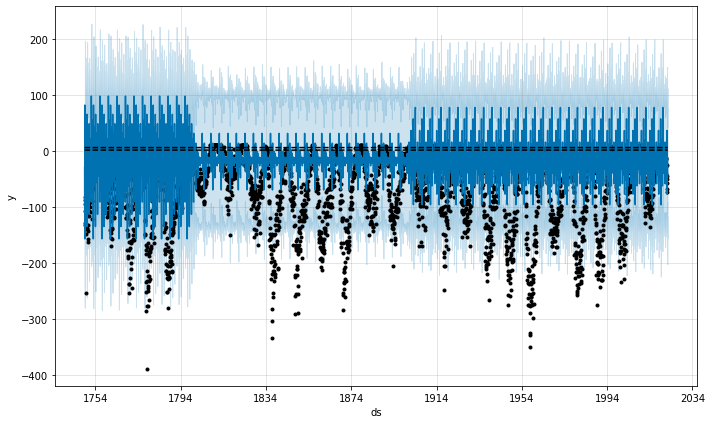

In [ ]:
mdf["y"] = 10 - mdf["y"]
mdf["cap"] = 6
mdf["floor"] = 1.5
future1["cap"] = 6
future1["floor"] = 1.5
model = Prophet(growth = "logistic")
model.fit(mdf)
logistic1_prediction = model.predict(future1)
fig = model.plot(logistic1_prediction)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


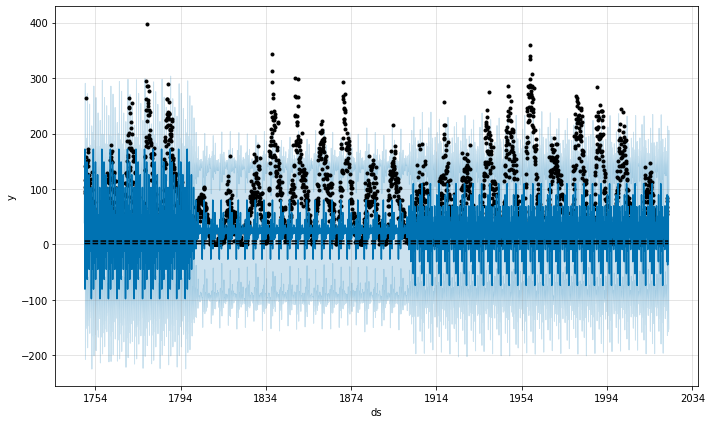

In [ ]:
mdf["y"] = 10 - mdf["y"]
mdf["cap"] = 6
mdf["floor"] = 1.5
future6["cap"] = 6
future6["floor"] = 1.5
model = Prophet(growth = "logistic")
model.fit(mdf)
logistic6_prediction = model.predict(future6)
fig = model.plot(logistic6_prediction)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


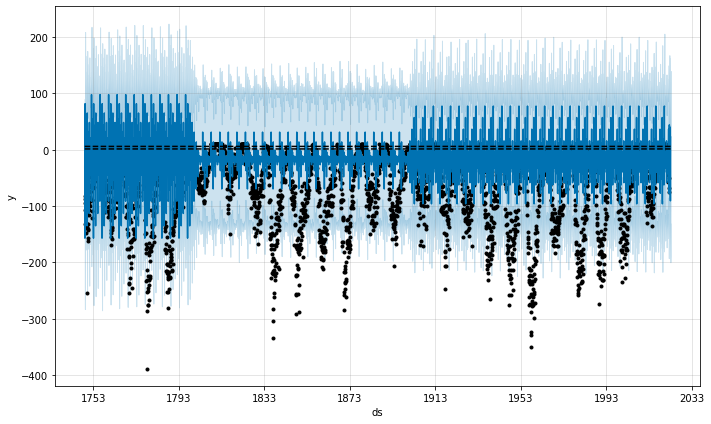

In [ ]:
mdf["y"] = 10 - mdf["y"]
mdf["cap"] = 6
mdf["floor"] = 1.5
future9["cap"] = 6
future9["floor"] = 1.5
model = Prophet(growth = "logistic")
model.fit(mdf)
logistic9_prediction = model.predict(future9)
fig = model.plot(logistic9_prediction)

In [ ]:
model = Prophet(growth = "flat")
model.fit(mdf)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


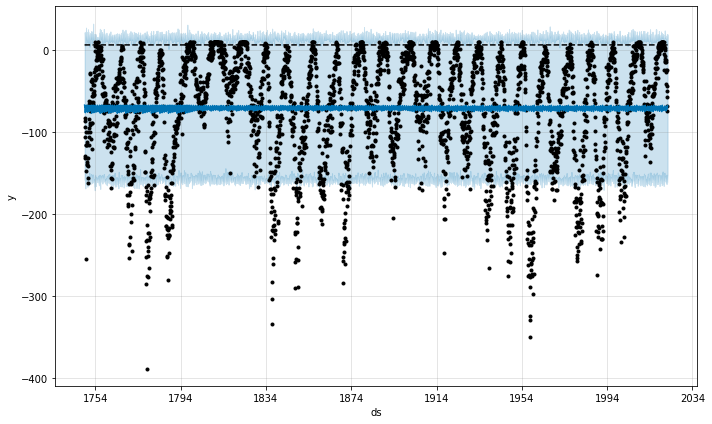

In [ ]:
flat1_prediction = model.predict(future1)
fig = model.plot(flat1_prediction)

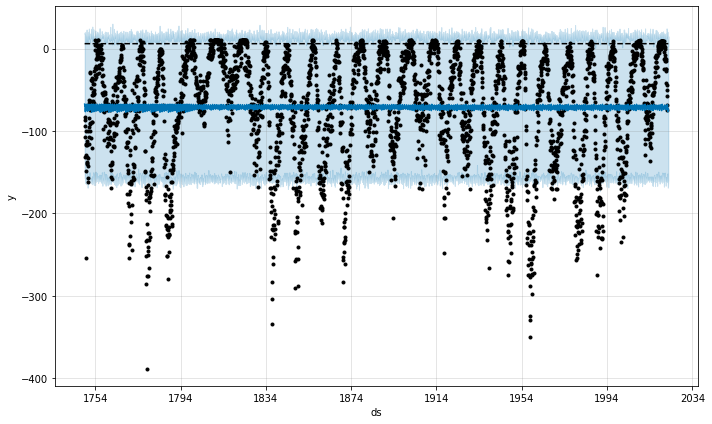

In [ ]:
flat6_prediction = model.predict(future6)
fig = model.plot(flat6_prediction)

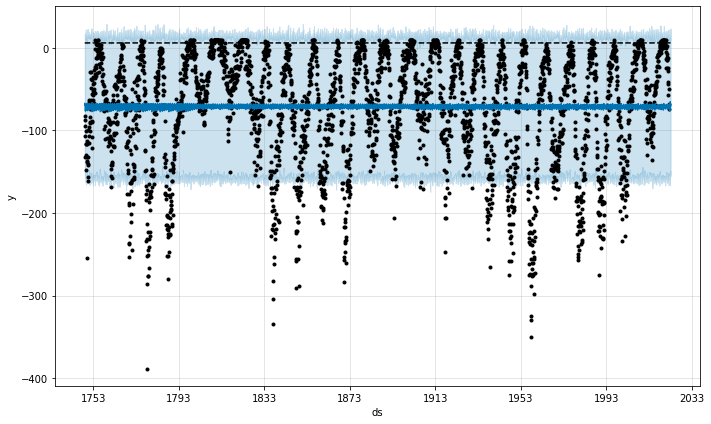

In [ ]:
flat9_prediction = model.predict(future9)
fig = model.plot(flat9_prediction)

#### Trend Changepoints

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


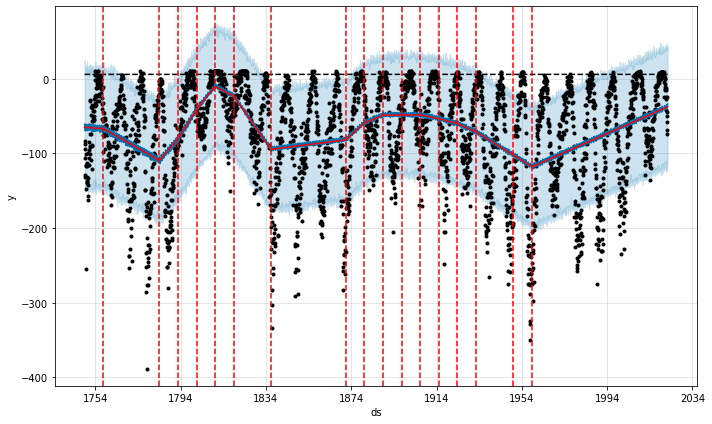

In [ ]:
from prophet.plot import add_changepoints_to_plot
model = Prophet(changepoint_prior_scale = 0.5)
prediction = model.fit(mdf)
trend1_prediction = prediction.predict(future1)
fig = model.plot(trend1_prediction)
a1 = add_changepoints_to_plot(fig.gca(), model, trend1_prediction)

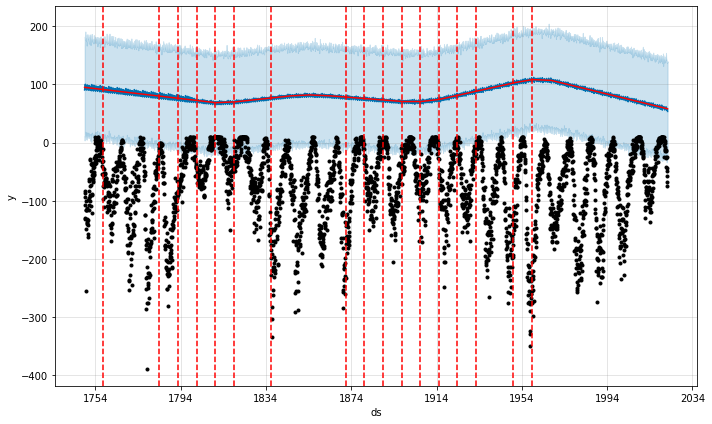

In [ ]:
fig = model.plot(linear1_prediction)
a1 = add_changepoints_to_plot(fig.gca(), model, linear1_prediction)

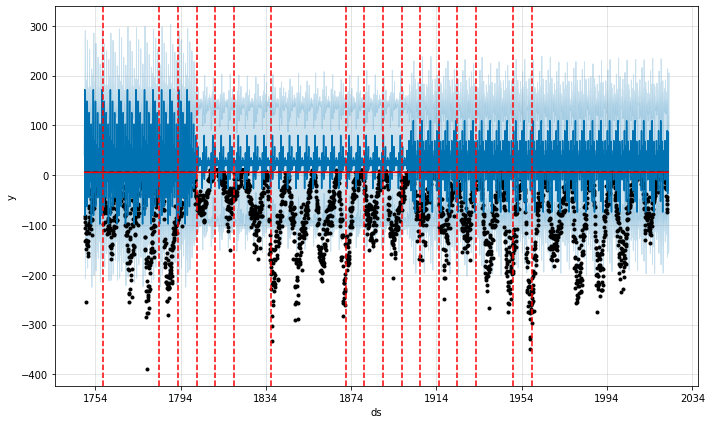

In [ ]:
fig = model.plot(logistic6_prediction)
a6 = add_changepoints_to_plot(fig.gca(), model, logistic6_prediction)

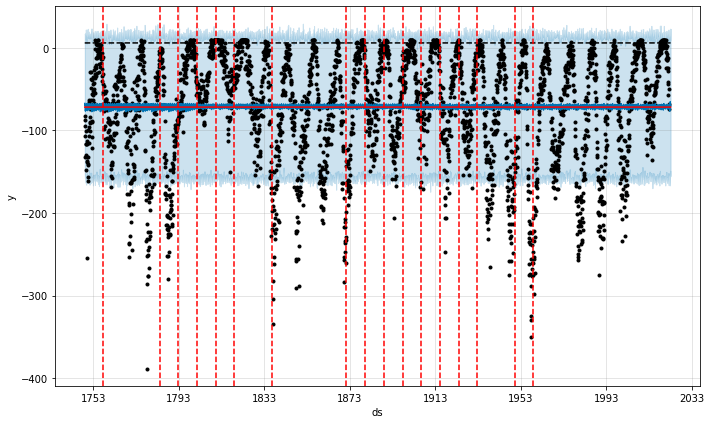

In [ ]:
fig = model.plot(flat9_prediction)
a9 = add_changepoints_to_plot(fig.gca(), model, flat9_prediction)

### Evaluate models by providing respective MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and R^2(use sklearn’s respective metrics).

logistic 10
logistic 20
logistic 30
linear 10
linear 20
linear 30
flat 10
flat 20
flat 30


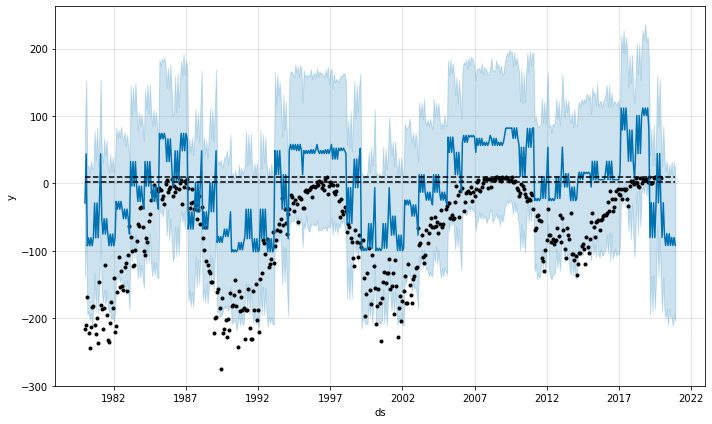

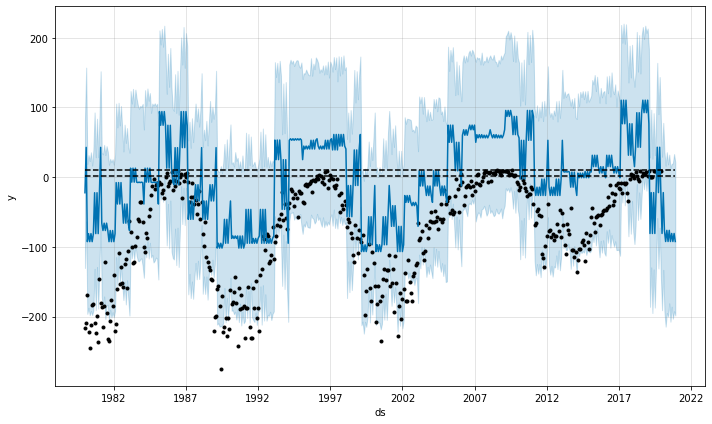

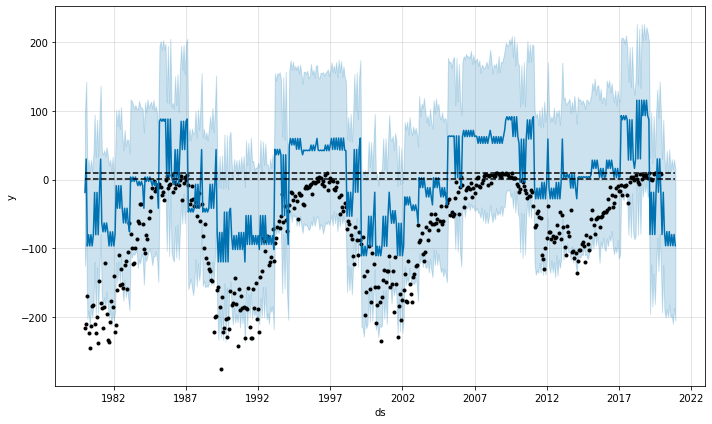

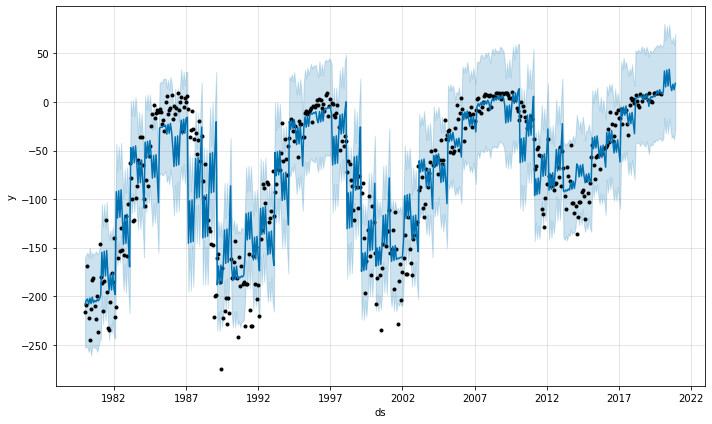

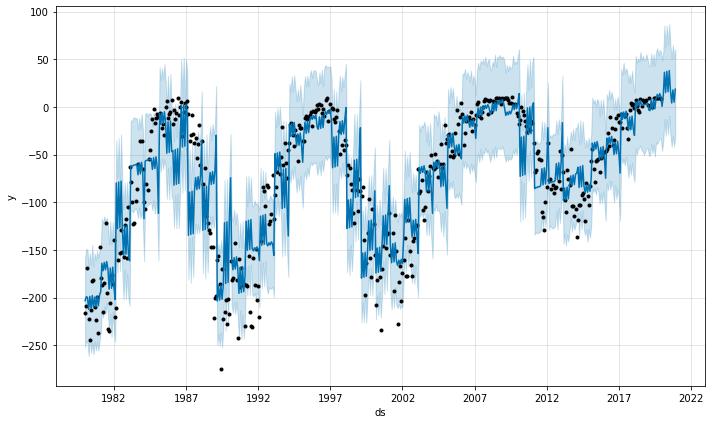

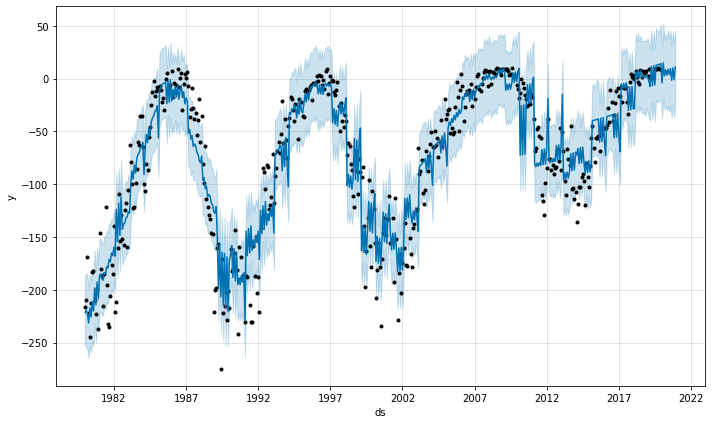

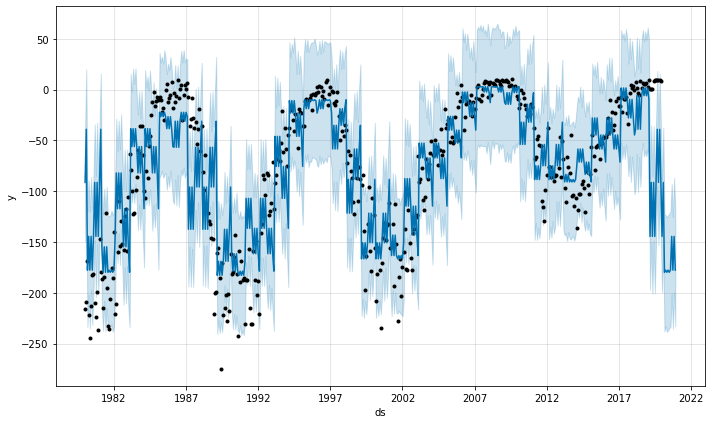

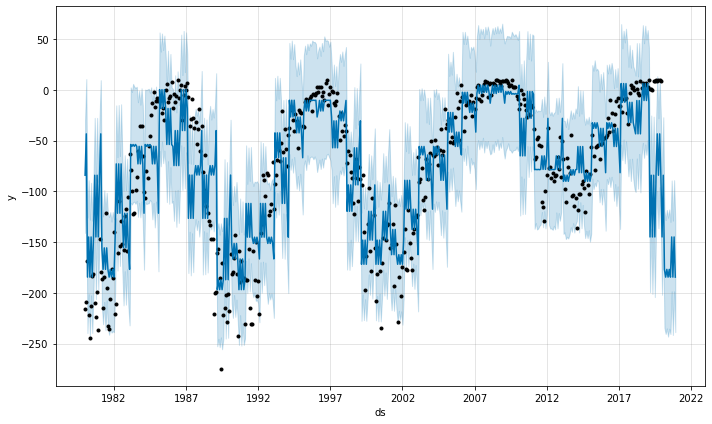

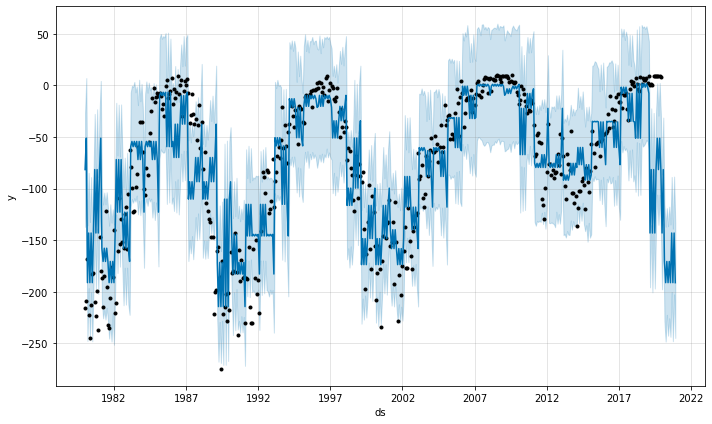

In [ ]:
results = pd.DataFrame(columns = ["MAE", "MAPE", "R2", "Growth", "Value"])
mdf1 = mdf.copy()
mdf1 = mdf1.loc[m1["year"].between(1980, 2022)]
mdf1["cap"] = int(max(mdf.iloc[:12*40, 1]))
mdf1["floor"] = 1.5

for growth in ["logistic", "linear", "flat"]:
  for value in [10, 20, 30]:
    model = Prophet(daily_seasonality = False,
                    weekly_seasonality = False,
                    yearly_seasonality = False,
                    growth = growth,
                    changepoint_prior_scale = value/100,
                    n_changepoints=value).add_seasonality(name = "monthly",
                                                          period = 30.5,
                                                          fourier_order = value)
    if growth == "logistic":
      model.fit(mdf1.iloc[:12*40,:])
    else:
      model.fit(mdf1.iloc[:12*40,:])

    future = model.make_future_dataframe(periods = 12, freq = "M")

    if growth == "logistic":
      future["cap"] = int(max(mdf1.iloc[:12*40, 1]))
      future["floor"] = 1.5

    prediction = model.predict(future)
    print(growth + " " + str(value))
    model.plot(prediction, uncertainty = True)
    results = results.append({"MAE": mean_absolute_error(mdf.iloc[(12*40): (12*41), 1], prediction["yhat"][-12:]),
                              "MAPE":mean_absolute_percentage_error(mdf.iloc[(12*40): (12*41), 1], prediction["yhat"][-12:]),
                              "R2": r2_score(mdf.iloc[(12*40): (12*41), 1], prediction["yhat"][-12:]),
                              "Growth": growth,
                              "Value": value}, ignore_index=True)

In [ ]:
results

MAE      MAPE          R2    Growth Value
0  107.445533  0.566295  -29.506434  logistic    10
1  107.321370  0.565469  -29.609534  logistic    20
2  106.514267  0.560513  -29.466432  logistic    30
3  205.897731  1.103095 -104.383454    linear    10
4  204.895632  1.097612 -103.568202    linear    20
5  192.296187  1.029992  -90.913178    linear    30
6   33.158136  0.175989   -3.629525      flat    10
7   33.815601  0.181339   -3.982946      flat    20
8   35.664734  0.193062   -4.433497      flat    30